In [1]:
import sys
import os
import numpy as np
from pathlib import Path

# Add the path to 'lib' directory
sys.path.append(os.path.abspath(os.path.join('..', 'lib')))

# Now try importing
from calibration.cv2api.calibrate import read_chessboards,calibrate_camera
from calibration.cv2api.detect import detect_pose
from config.ConfigManager import ConfigManager
from calibration.json_utils.json_functions import generate_json_for_images

config_manager = ConfigManager('config.json')


def calibrate_and_write(project_name,  output_folder):

    image_files = [os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith(".jpg")]
    image_files.sort()  # Ensure files are in order

    allCorners,allIds,imsize,num_of_detected_markers=read_chessboards(image_files)

    #print(allCorners)


    ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)

    if(ret>0):
        np.save(os.path.join(output_folder,"camera_matrix.npy"), mtx)
        np.save(os.path.join(output_folder,"camera_dist_coeff.npy"),dist)
        config_manager.update_project(project_name, {"calibrated": True, "camera_matrix": mtx.tolist(),
                                                "dist_coeff": dist.tolist()})
    else:
        print("no calibration data were found")

    return mtx,dist



# input_video = "../data/videos/bfrog_4x4.mp4"
# input_folder = None

input = "../data/images/calib"

output_folder = f"../data/images/{Path(input).stem}"
project_name = "test"
mtx = None
dist = None
num_of_images = 40

if(os.path.isdir(input)):
    config_manager.update_project(project_name, {"images": output_folder})
    mtx,dist = calibrate_and_write(project_name, output_folder)
else:
    err = os.system(f"sfextract --frame-count {num_of_images} {input} --output {output_folder}")  
    if(err):
        print("Error occured while generating images from video")
    else:
        config_manager.update_project(project_name, {"images": output_folder})
        mtx,dist = calibrate_and_write("test", output_folder)






Calibration package is being initialized.
POSE ESTIMATION STARTS:
=> Processing image ../data/images/calib\frame0000.jpg
=> Processing image ../data/images/calib\frame0001.jpg
=> Processing image ../data/images/calib\frame0002.jpg
=> Processing image ../data/images/calib\frame0003.jpg
=> Processing image ../data/images/calib\frame0004.jpg
=> Processing image ../data/images/calib\frame0005.jpg
=> Processing image ../data/images/calib\frame0006.jpg
=> Processing image ../data/images/calib\frame0007.jpg
=> Processing image ../data/images/calib\frame0008.jpg
=> Processing image ../data/images/calib\frame0009.jpg
=> Processing image ../data/images/calib\frame0010.jpg
=> Processing image ../data/images/calib\frame0011.jpg
=> Processing image ../data/images/calib\frame0012.jpg
=> Processing image ../data/images/calib\frame0013.jpg
=> Processing image ../data/images/calib\frame0014.jpg
=> Processing image ../data/images/calib\frame0015.jpg
=> Processing image ../data/images/calib\frame0016.jpg

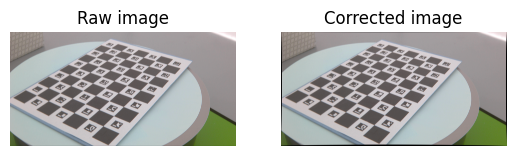

In [2]:
from matplotlib import pyplot as plt
import cv2


def undistort_image(image, camera_matrix, dist_coeffs):
    h, w = image.shape[:2]
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))
    undistorted_image = cv2.undistort(image, camera_matrix, dist_coeffs, None, new_camera_matrix)
    return undistorted_image

i=15 # select image id
plt.figure()
frame = cv2.imread("../data/images/calib"+"/frame0009.jpg")
img_undist = undistort_image(frame,mtx,dist)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()


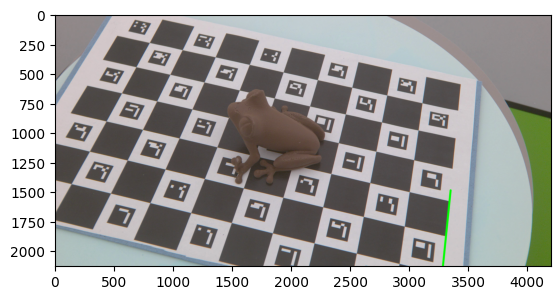

In [3]:
generate_json_for_images("../data/images/calibration/",os.path.join("../data/images/calibration/","transforms_centered.json"),mtx,dist,colmap = True)